In [0]:
# install some packages not available on colab
!pip install mrcfile
!pip install -U -q PyDrive

In [0]:
# IGNORE these few cells if you are running this nb locally
# this part links your google drive to this colab notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# once you run this, click on the link and copy the validation code here
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# upload the .mrc file onto google drive and paste the sharing link below
# currently using the "May08_03.05.02.bin.mrc" from the EMPIAR 10146 dataset (apoferritin)
link = "https://drive.google.com/open?id=15he2DJIFYJdjfN2Nf3SAvq6Blmj1IxBN"

In [0]:
fluff, id = link.split('=')

In [0]:
# we will use the id part to get the file contents
print(id)May08_03.05.02.bin.mrc

15he2DJIFYJdjfN2Nf3SAvq6Blmj1IxBN


In [0]:
downloaded = drive.CreateFile({'id':id}) 
# replace filename if necessary
downloaded.GetContentFile('May08_03.05.02.bin.mrc')

In [1]:
# start of actual process to open mrc file
import mrcfile
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
# replace file name if necessary
mrc = mrcfile.open('./test_data/stack1.mrc',mode='r')

In [6]:
img_stack=np.copy(mrc.data)

In [7]:
# mrc data type is a float type
img_stack.dtype

dtype('<f4')

In [8]:
img_stack.shape

(50, 600, 620)

In [9]:
img_stack[1,:4,:4]

array([[2.6967125, 2.2851052, 2.8535361, 2.8592756],
       [7.501983 , 6.081748 , 4.839926 , 6.369596 ],
       [7.1509123, 7.672936 , 6.193481 , 6.302643 ],
       [7.6303153, 9.701217 , 6.2700443, 6.477514 ]], dtype=float32)

In [10]:
org_min, org_max = np.min(img_stack), np.max(img_stack)

In [11]:
# convert floating type to int type between 0 and 255 (inclusive)
norm_stack=cv2.normalize(img_stack, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [12]:
norm_stack.shape

(50, 600, 620)

In [13]:
norm_stack[1,:4,:4]

array([[ 47.863705,  41.52155 ,  50.280087,  50.368523],
       [121.904625, 100.021255,  80.88692 , 104.4565  ],
       [116.495224, 124.53871 , 101.74287 , 103.42486 ],
       [123.881996, 155.79102 , 102.92258 , 106.11932 ]], dtype=float32)

In [14]:
norm_stack_expanded=np.expand_dims(norm_stack,axis=3)

In [15]:
norm_stack_expanded.shape

(50, 600, 620, 1)

In [16]:
# do a 2d transform for a stack of images
def transform_2d(image_stack):
  transformed_stack = np.zeros(image_stack.shape,dtype='float32')
  for i in range(transformed_stack.shape[0]):
    transformed_stack[i] = cv2.dct(image_stack[i])
  return transformed_stack

In [17]:
# reverse the 2d transform
def reverse_transform_2d(transformed_stack):
  filtered_stack = np.zeros(transformed_stack.shape)
  for i in range(filtered_stack.shape[0]):
    filtered_stack[i] = cv2.idct(transformed_stack[i])
  return filtered_stack

In [18]:
# threshold is a certain value multiplied by sigma
sigma=10
Threshold_Hard3D = 2.7*sigma

def Step1_3DFiltering_color(_similar_blocks):
    t1 = cv2.getTickCount()
    chnl = _similar_blocks.shape[3] # chnl = 3 for color image
    # statis_nonzero = np.zeros(chnl, dtype=int)
    m_Shape = _similar_blocks.shape
    new_blocks = np.zeros(_similar_blocks.shape)
    # print("similar blocks shape", _similar_blocks.shape)avg_frame

    # code below is computationally expensive

    # for each pixel location at each channel, do cosine transform, hard thresholding and cosine transform back
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            for ch in range(chnl):
                tem_Vct_Trans = cv2.dct(_similar_blocks[:, i, j, ch])
                tem_Vct_Trans[np.abs(tem_Vct_Trans[:]) < Threshold_Hard3D] = 0.
                # statis_nonzero[ch] += tem_Vct_Trans.nonzero()[0].size
                new_blocks[:, i, j, ch] = cv2.idct(tem_Vct_Trans).flatten()
    t2 = cv2.getTickCount()
    time = (t2-t1)/cv2.getTickFrequency()
    print("Initial step processing time taken is {} seconds".format(time))
    return new_blocks

In [22]:
# sigma can be adjusted
sigma_color = [0, 0, 0]
sigma_color[0] = np.sqrt(0.299*0.299 + 0.587*0.587 + 0.114*0.144)*sigma
sigma_color[1] = np.sqrt(0.169*0.169 + 0.331*0.331 + 0.5*0.5)*sigma
sigma_color[2] = np.sqrt(0.5*0.5 + 0.419*0.419 + 0.081*0.081)*sigma

def Step2_3DFiltering_color(_Similar_Bscs, _Similar_Imgs):
    t1 = cv2.getTickCount()
    chnl = _Similar_Bscs.shape[3] # chnl = 3 for color image
    m_Shape = _Similar_Bscs.shape
    # Wiener_wight = np.zeros((m_Shape[1], m_Shape[2], m_Shape[3]), dtype=float)
    Count = _Similar_Bscs.shape[0]
    final_blocks = np.zeros(_Similar_Bscs.shape)
    # Wiener filtering
    for i in range(m_Shape[1]):
        for j in range(m_Shape[2]):
            for ch in range(chnl):
                tem_vector = _Similar_Bscs[:, i, j, ch]
                tem_Vct_Trans = np.matrix(cv2.dct(tem_vector))
                # find the l2 norm
                Norm_2 = np.float64(tem_Vct_Trans.T * tem_Vct_Trans)

                m_weight = Norm_2/Count/(Norm_2/Count + sigma_color[ch]**2)
                # print("m weight shape", m_weight.shape)
                # print("m_weight = "+str(m_weight))

                tem_vector = _Similar_Imgs[:, i, j, ch]
                tem_Vct_Trans = m_weight * cv2.dct(tem_vector)
                final_blocks[:, i, j, ch] = cv2.idct(tem_Vct_Trans).flatten()
    t2 = cv2.getTickCount()
    time = (t2-t1)/cv2.getTickFrequency()
    print("Final step processing time taken is {} seconds".format(time))
    return final_blocks

In [23]:
def bm3d_cycle(image_stack):
  transformed_stack = transform_2d(image_stack)
  transformed_stack_expanded = np.expand_dims(transformed_stack,axis=3)
  basic_blocks = Step1_3DFiltering_color(transformed_stack_expanded)    
  final_blocks = Step2_3DFiltering_color(basic_blocks, transformed_stack_expanded)
  final_blocks_squeezed = np.squeeze(final_blocks)
  filtered_stack = reverse_transform_2d(final_blocks_squeezed)
  return filtered_stack

In [24]:
filtered_stack = bm3d_cycle(norm_stack)

Initial step processing time taken is 3.915516055 seconds
Final step processing time taken is 9.171350919 seconds


In [25]:
# get the original average frame
avg_frame = norm_stack.mean(axis=0)

In [26]:
# get the filtered average frame
avg_filtered_frame = filtered_stack.mean(axis=0)

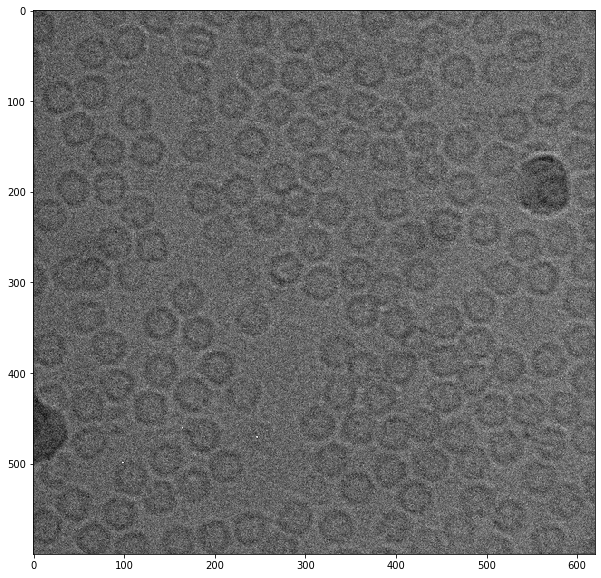

In [27]:
plt.figure(figsize=(20,10))
plt.imshow(img_stack.mean(axis=0),cmap='gray')
plt.show()

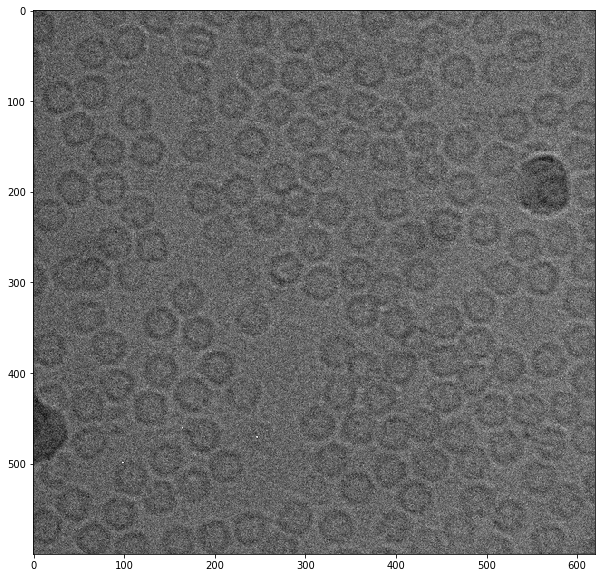

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(avg_frame,cmap='gray')
plt.show()

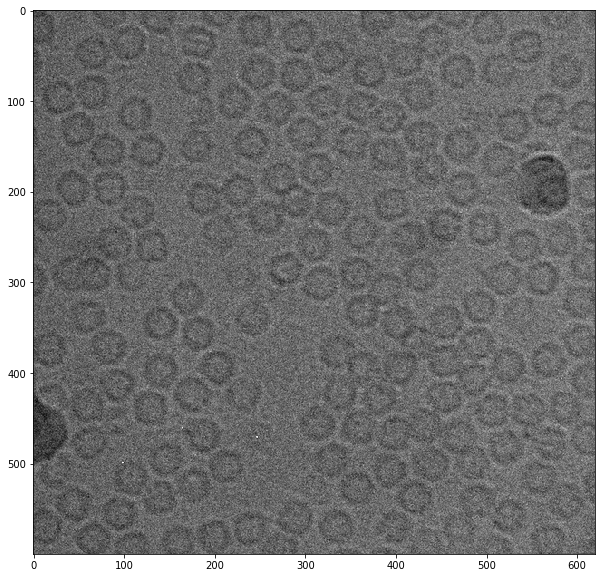

In [29]:
plt.figure(figsize=(20,10))
plt.imshow(avg_filtered_frame,cmap='gray')
plt.show()

In [30]:
filtered_stack.shape

(50, 600, 620)

In [31]:
scaled_filtered = cv2.normalize(filtered_stack, None, alpha = org_min, beta = org_max, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

In [32]:
with mrcfile.new('./apoferritin_low/bm3d_filtered.mrc') as mrc:
    mrc.set_data(scaled_filtered)

FileNotFoundError: [Errno 2] No such file or directory: './apoferritin_low/bm3d_filtered.mrc'

Add random gaussian noise

In [34]:
mini_avg_frame=avg_frame[150:350,:200]

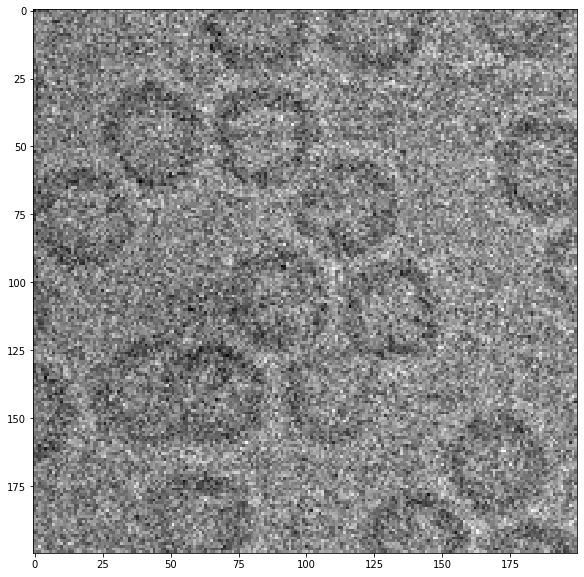

In [35]:
plt.figure(figsize=(20,10))
plt.imshow(mini_avg_frame,cmap='gray')
plt.show()

In [36]:
def make_noisy_stack(original_frame, sigma, num_frames):
  noisy_stack = np.zeros((num_frames,)+original_frame.shape)
  for i in range(num_frames):
    noise = np.random.normal(loc=128,scale=sigma, size=mini_avg_frame.shape).astype(np.int32)
    noisy_stack[i] = mini_avg_frame + noise
  return noisy_stack

In [37]:
noisy_stack = make_noisy_stack(mini_avg_frame, sigma, 200)

Sample from noisy stack

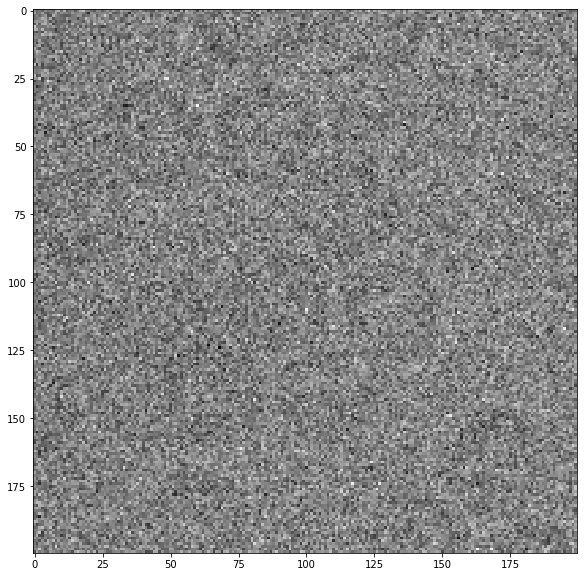

In [38]:
plt.figure(figsize=(20,10))
plt.imshow(noisy_stack[0],cmap='gray')
plt.show()

Get the filtered stack and then plot

In [39]:
filtered_stack = bm3d_cycle(noisy_stack)

Initial step processing time taken is 0.8140907 seconds
Final step processing time taken is 1.483642471 seconds


In [40]:
avg_filtered_noisy = filtered_stack.mean(axis=0)

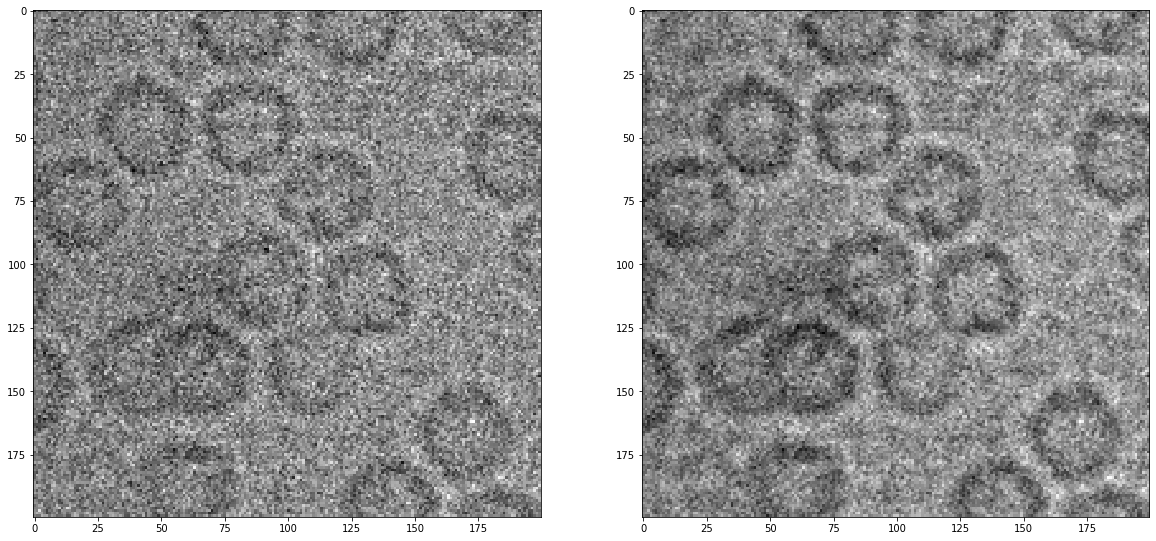

In [41]:
fig = plt.figure(figsize=(20,30))
fig.add_subplot(121)   #bottom left

plt.imshow(mini_avg_frame,cmap='gray')
fig.add_subplot(122)   #bottom right 
plt.imshow(avg_filtered_noisy,cmap='gray')
plt.show()

Getting the PSNR


In [ ]:
def PSNR2(img1, img2):
    D = np.array(img2, dtype=np.int64) - np.array(img1, dtype=np.int64)
    D = D**2
    RMSE = D.sum()/img1.size
    psnr = 10*np.log10(float(255.**2)/RMSE)
    return psnr
